In [5]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import os
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=(10,10)

# 파일 읽기 : BTM_K GRS80 ->  WGS84 타원체 경위도로 변경완료

# 서울 토지 이용 유형
seoul_geo=gpd.read_file('G:/지니웍스 프로젝트/데이터/지도 데이터/토지이용유형/토지이용유형_경위도.shp')
seoul_geo.columns=['고유번호', '면적', '토지이용', '건폐율', '불투포장율', '투수포장율', '녹지율', '기타비율', '불투토포비',
       '현존식생', '우점종식생', '비오톱유형', '자치구', '이용범례', '식생범례', '포장범례', '비오톱범례',
       '유형평가', '개별평가', 'geometry']
seoul_geo=seoul_geo[['geometry','비오톱유형']]

#중구 지도
jungu=gpd.read_file('G:/지니웍스 프로젝트/데이터/지도 데이터/서울시/중구/jung_gu_real_84.shp')

# 중구 grid - 25개
jungu_grid=gpd.read_file('G:/지니웍스 프로젝트/데이터/지도 데이터/서울시/중구/jung_gu_grid_009.shp')
jungu_grid['grid_num']=jungu_grid.index+1

# data : 중구의 신고 데이터 : 엑셀에 잇는 것을 gpd.GeoPandas file로 변환
data=pd.read_csv('G:/지니웍스 프로젝트/데이터/중구 신고 데이터/통합본.csv',encoding='utf-8')
jungu_report=gpd.GeoDataFrame(data,geometry=gpd.points_from_xy(data.y,data.x))

In [25]:
# 각 grid 별 centroid 추가
jungu_grid['centroid']=jungu_grid.centroid

<ipython-input-25-04762a27f6f8>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  jungu_grid['centroid']=jungu_grid.centroid


In [7]:
# 비오톱 유형 simplified
import re 
seoul_geo['비오톱유형_simplified']=seoul_geo['비오톱유형'].apply(lambda i: re.sub('[0-9]','',i))
seoul_geo.loc[:,['geometry','비오톱유형_simplified']].head(10)

,geometry,비오톱유형_simplified
0,"POLYGON ((126.99703 37.53983, 126.99702 37.539...",H
1,"POLYGON ((126.98112 37.53517, 126.98101 37.535...",C
2,"POLYGON ((126.97837 37.53497, 126.97823 37.534...",C
3,"POLYGON ((126.97844 37.53393, 126.97839 37.533...",C
4,"POLYGON ((126.98097 37.53266, 126.97980 37.532...",C
5,"POLYGON ((126.98024 37.53410, 126.98019 37.534...",C
6,"POLYGON ((126.97993 37.53437, 126.97995 37.533...",C
7,"POLYGON ((126.97879 37.53385, 126.97855 37.533...",C
8,"POLYGON ((126.97844 37.53393, 126.97847 37.533...",C
9,"POLYGON ((126.99190 37.53351, 126.99160 37.533...",H


In [8]:
print(9.96/len(set(jungu_grid.grid_num)))
print(len(set(jungu_grid.grid_num))) # 34개

0.39840000000000003
25


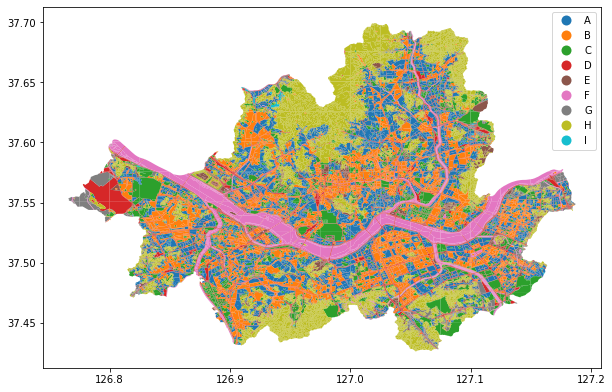

In [9]:
seoul_geo.plot(column='비오톱유형_simplified',legend=True,categorical=True)

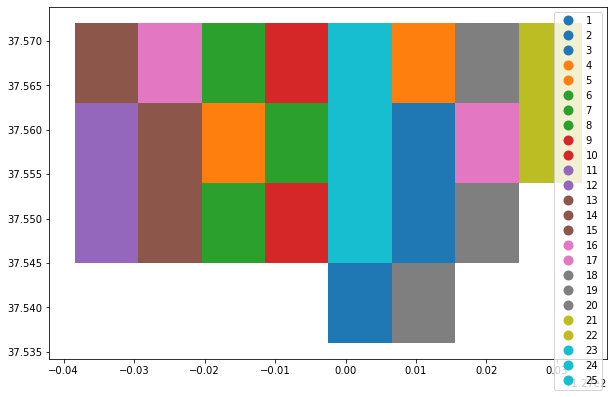

In [29]:
# jungu grid 그림
jungu_grid.plot(column='grid_num',categorical=True,legend=True)

In [30]:
jungu_report.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199)
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199)
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199)
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199)
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199)


In [31]:
# data frame 형태로 만들기
spartial_joins_1=gpd.sjoin(jungu_report,jungu_grid,how='left',op='within') # jungu의 그리드
spartial_joins_2=gpd.sjoin(jungu_report,seoul_geo,how='left',op='within') #  jungu의 비오톱유형

<ipython-input-31-2c666e4ada0c>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  spartial_joins_1=gpd.sjoin(jungu_report,jungu_grid,how='left',op='within') # jungu의 그리드


In [32]:
# 지도 데이터가 올바르지 못한 경우 제거
spartial_joins_1=spartial_joins_1.dropna()
spartial_joins_2=spartial_joins_2.dropna()

In [33]:
# grid num int로 변환
spartial_joins_1.grid_num=spartial_joins_1.grid_num.astype(int)

In [34]:
spartial_joins_1.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry,index_right,id,left,top,right,bottom,grid_num,centroid
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2,POINT (127.01106 37.54952)
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2,POINT (127.01106 37.54952)
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2,POINT (127.01106 37.54952)
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2,POINT (127.01106 37.54952)
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2,POINT (127.01106 37.54952)


In [35]:
spartial_joins_2.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry,index_right,비오톱유형,비오톱유형_simplified
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),6894.0,A1,A
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),6894.0,A1,A
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),6894.0,A1,A
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),6894.0,A1,A
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),6894.0,A1,A


In [36]:
# grid에 해당하는 불법 주정차 단속 건수
print('total grid 개수 : 25개')
print('이 중 활용된 grid 개수 : %d개'%(len(set(spartial_joins_1.grid_num))))

for i in sorted(list(set(spartial_joins_1.grid_num))):
    print('grid num %s :'%int(i),end=' ')
    print((spartial_joins_1['grid_num']==i).sum())

total grid 개수 : 25개
이 중 활용된 grid 개수 : 23개
grid num 1 : 23464
grid num 2 : 13912
grid num 4 : 48515
grid num 5 : 49632
grid num 6 : 6
grid num 7 : 32695
grid num 8 : 55787
grid num 9 : 21
grid num 10 : 95906
grid num 11 : 22838
grid num 12 : 1923
grid num 13 : 3497
grid num 14 : 44520
grid num 15 : 3
grid num 16 : 30156
grid num 17 : 17308
grid num 18 : 28
grid num 20 : 42583
grid num 21 : 1
grid num 22 : 102
grid num 23 : 33949
grid num 24 : 11170
grid num 25 : 107535


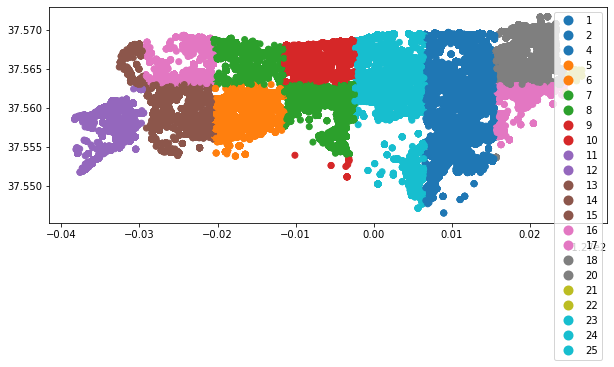

In [49]:
spartial_joins_1.plot(column='grid_num',legend=True,categorical=True)

# Rule based
grid 6, gird, 21, grid 15, grid 18, grid 21, grid 22는 제외

In [19]:
spartial_joins_1.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry,index_right,id,left,top,right,bottom,grid_num
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),1.0,23.0,127.006559,37.554023,127.015559,37.545023,2


In [50]:
print('total data 개수 : %d'%len(spartial_joins_2))
for i in set(spartial_joins_2.비오톱유형_simplified): # G는 없다.
    print('비오톱 유형 %s'%i,end=' ')
    print((spartial_joins_2['비오톱유형_simplified']==i).sum())

total data 개수 : 635551
비오톱 유형 H 2338
비오톱 유형 F 11034
비오톱 유형 I 309
비오톱 유형 D 156945
비오톱 유형 A 46173
비오톱 유형 B 317541
비오톱 유형 E 33130
비오톱 유형 C 68081


# 비오톱 유형 분류 
A : 주거지 비오톱
B : 상업 및 업무지
C : 공업지 및 도시기반시설지
D : 교통시설
E : 조경녹지
F : 하천 및 습지
G : 경작지
H : 산림지
I : 유휴지
-> EDA 결과 F,G,H,I는 ETC로 통합하자

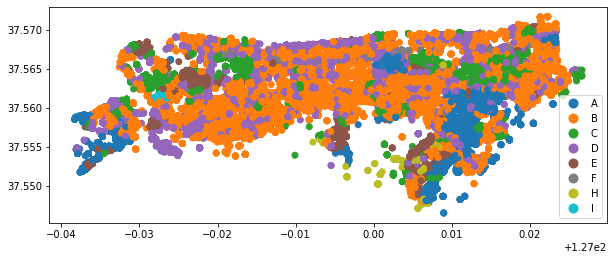

In [51]:
spartial_joins_2.plot(column='비오톱유형_simplified',legend=True,categorical=True)

# BUT
RNN으로 진행하면 train과 test의 data의 불일치가 발생한다.(GRID 또는 비오톱 유형 모두)
결국 RandomForest를 활용해서, 각 feature(공휴일, 월, 일, 시간, GRID, 비오톱 유형, 하루 4등분 등)으로 분류하는 수 밖에 없다.

In [82]:
spartial_joins_1.to_csv('./spartial_joins_1.csv')

In [54]:
spartial_joins_1['index']=spartial_joins_1.index
spartial_joins_2['index']=spartial_joins_2.index

In [56]:
# index를 기준으로 left로 join
total=pd.merge(spartial_joins_1,spartial_joins_2,how='left')

In [57]:
spartial_joins_1['비오톱유형']=spartial_joins_2['비오톱유형_simplified']

In [52]:
import datetime as dt

In [58]:
# 최종적인 데이터
total_data=spartial_joins_1.loc[:,['시군구명', '단속일시', '단속동', '단속장소', '단속조_index', 'place', 'x', 'y','geometry','grid_num','비오톱유형']]
total_data['date']=total_data['단속일시'].apply(lambda i : dt.datetime.strptime(i,'%Y-%m-%d %H:%M'))

In [59]:
total_data.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry,grid_num,비오톱유형,date
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,A,2015-01-01 00:13:00
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,A,2015-01-01 00:14:00
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,A,2015-01-01 00:15:00
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,A,2015-03-16 21:08:00
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,A,2015-03-16 21:08:00


In [79]:
total_data.to_csv('./total_data.csv',index=False)

(array([3.01447e+05, 1.63990e+04, 1.82000e+03, 0.00000e+00, 3.98700e+04,
        1.20000e+01, 0.00000e+00, 5.91340e+04, 2.12940e+04, 1.95575e+05]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <a list of 10 Patch objects>)

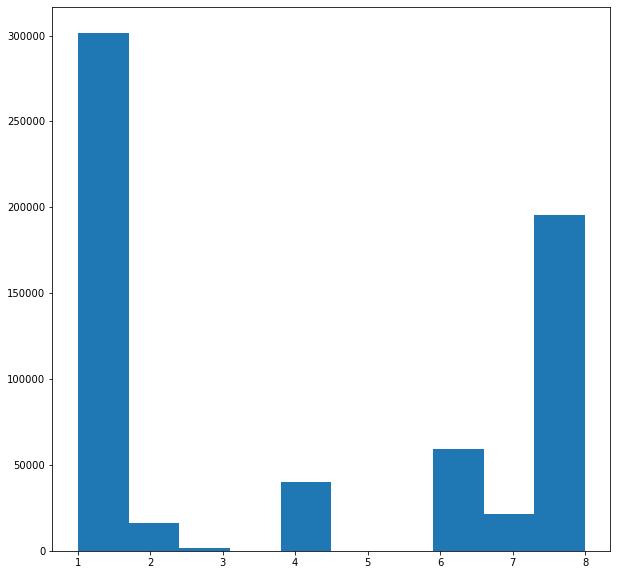

In [60]:
plt.hist(total_data.단속조_index)

In [ ]:
'''
    중구청 인력 단속 : 1
    중구청 주행형 CCTV : 2
    경찰서, 소방서 : 3
    시청 인력 단속 : 4
    시청 주행형 CCTV : 5
    시청 고정형 CCTV : 6
    주민신고 : 7
    중구청 고정형 CCTV : 8
    '''

In [61]:
# 비오톱 유형 통합
def simplified(data_i):
    if data_i in ['F','G','H','I']:
        return 'ETC'
    else:
        return data_i
total_data['비오톱유형']=total_data['비오톱유형'].apply(lambda i : simplified(i))

In [62]:
def time_zone(data_i):
    if data_i>=6 and data_i<12:
        return 0
    if data_i>=12 and data_i<6:
        return 1
    if data_i>=6 and data_i<11:
        return 2
    else:
        return 4

In [63]:
def make_time(data_i):
    if len(str(data_i))==1:
        return '0'+str(data_i)
    else:
        return str(data_i)

In [64]:
# Holiday 가져오기
import requests
holiday=[]
for year in range(2015,2021):
    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
        URL = "http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getHoliDeInfo?ServiceKey=SHKN0mFGJKABDNHU9MEyR3vq4%2BE5jaHvVaP8eUt2JgOX1tIWGtc3JvTbwr4a2MRDYa6ONNE0tb7ADSabcrBT7w%3D%3D&_type=json&solYear={year}&solMonth={month}".format(year=year,month=month)
        html = requests.get(URL)
        if html.json()['response']['body']['items']:
            try:
                holiday.append(html.json()['response']['body']['items']['item']['locdate'])
            except:
                for i in html.json()['response']['body']['items']['item']:
                    holiday.append(i['locdate'])               

In [65]:
# int 2 str
holiday=[str(i) for i in holiday]

In [66]:
# 비오톱 유형 indexing
def c2index(data_i):
    for _,i in enumerate(['A','B','C','D','E','ETC']):
        if data_i == i:
            return _        

In [67]:
# 비오톱 유형 indexing
total_data['비오톱유형']=total_data['비오톱유형'].apply(lambda i : c2index(i))

In [78]:
total_data.head()

,시군구명,단속일시,단속동,단속장소,단속조_index,place,x,y,geometry,grid_num,비오톱유형,date
0,중구,2015-01-01 00:13,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,0,2015-01-01 00:13:00
1,중구,2015-01-01 00:14,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,0,2015-01-01 00:14:00
2,중구,2015-01-01 00:15,신당동,다산로 128-9,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,0,2015-01-01 00:15:00
3,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,0,2015-03-16 21:08:00
4,중구,2015-03-16 21:08,신당동,다산로 128-9주변,1,신당동 다산로 128-9,37.551987,127.007976,POINT (127.00798 37.55199),2,0,2015-03-16 21:08:00


In [ ]:
## 비오톱 유형별로 time, month, days, hour, 비오톱유형, 요일, 시간대, 공휴일로 feature 만들기
## 단속건수 0 or 1로 

In [70]:
# 하루를 24등분해서 2015년 1월 1일부터 2020년 7월 14일까지의 데이터를 작성 
# 비오톱유형
for j in set(total_data.비오톱유형):
    x=total_data.loc[total_data['비오톱유형']==j,:]
    new_data=df(index=pd.date_range('2015-01-01','2020-07-14',freq='H'))
    new_data['단속건수']=0
    for i in new_data.index:
        new_data['단속건수'][i]=((i<=x.date) & (x.date<i+dt.timedelta(hours=1))).sum()
    # date란 feature을 만들어주자
    new_data['date']=new_data.index
    new_data['time']=new_data['date'].apply(lambda i : str(i.year) + make_time(i.month) + make_time(i.day))
    new_data['month']=new_data['date'].apply(lambda i : i.month)
    new_data['days']=new_data['date'].apply(lambda i : i.day)
    new_data['hour']=new_data['date'].apply(lambda i : i.hour)
    new_data['비오톱유형']=j
    new_data['요일']=new_data['date'].apply(lambda i : dt.datetime.weekday(i)) # 0 : 월 ~ 6 : 일
    new_data['시간대']=new_data['hour'].apply(lambda i : time_zone(i))
    new_data['공휴일']=(new_data['요일']==6) # 공휴일 추가해야됨 지금까진 일요일만 공휴일로 취급
    new_data['공휴일']=new_data.공휴일.astype(int)
    new_data['공휴일_']=new_data['time'].apply(lambda i : 1 if i in holiday else 0)
    new_data['holiday']=new_data['공휴일']+new_data['공휴일_']
    new_data['holiday']=new_data['holiday'].apply(lambda i : 1 if i>=1 else 0)               
    new_data[['month','days','hour','비오톱유형','요일','시간대','holiday','단속건수']].to_csv('./비오톱유형%d.csv'%j)

In [71]:
new_data.head()

,단속건수,date,time,month,days,hour,비오톱유형,요일,시간대,공휴일,공휴일_,holiday
2015-01-01 00:00:00,0,2015-01-01 00:00:00,20150101,1,1,0,5,3,4,0,1,1
2015-01-01 01:00:00,0,2015-01-01 01:00:00,20150101,1,1,1,5,3,4,0,1,1
2015-01-01 02:00:00,0,2015-01-01 02:00:00,20150101,1,1,2,5,3,4,0,1,1
2015-01-01 03:00:00,0,2015-01-01 03:00:00,20150101,1,1,3,5,3,4,0,1,1
2015-01-01 04:00:00,0,2015-01-01 04:00:00,20150101,1,1,4,5,3,4,0,1,1


In [72]:
# 하루를 24등분해서 2015년 1월 1일부터 2020년 7월 14일까지의 데이터를 작성 
# 일단 그리드만을 대상으로 작성

for j in set(total_data.grid_num):
    x=total_data.loc[total_data['grid_num']==j,:]
    new_data=df(index=pd.date_range('2015-01-01','2020-07-14',freq='H'))
    new_data['단속건수']=0
    for i in new_data.index:
        new_data['단속건수'][i]=((i<=x.date) & (x.date<i+dt.timedelta(hours=1))).sum()
    # date란 feature을 만들어주자
    new_data['date']=new_data.index
    new_data['time']=new_data['date'].apply(lambda i : str(i.year) + make_time(i.month) + make_time(i.day))
    new_data['month']=new_data['date'].apply(lambda i : i.month)
    new_data['days']=new_data['date'].apply(lambda i : i.day)
    new_data['hour']=new_data['date'].apply(lambda i : i.hour)
    new_data['grid_num']=j
    new_data['요일']=new_data['date'].apply(lambda i : dt.datetime.weekday(i)) # 0 : 월 ~ 6 : 일
    new_data['시간대']=new_data['hour'].apply(lambda i : time_zone(i))
    new_data['공휴일']=(new_data['요일']==6) # 공휴일 추가해야됨 지금까진 일요일만 공휴일로 취급
    new_data['공휴일']=new_data.공휴일.astype(int)
    new_data['공휴일_']=new_data['time'].apply(lambda i : 1 if i in holiday else 0)
    new_data['holiday']=new_data['공휴일']+new_data['공휴일_']
    new_data['holiday']=new_data['holiday'].apply(lambda i : 1 if i>=1 else 0)               
    new_data[['month','days','hour','grid_num','요일','시간대','holiday','단속건수']].to_csv('./그리드%d.csv'%j)

In [73]:
new_data.head()

,단속건수,date,time,month,days,hour,grid_num,요일,시간대,공휴일,공휴일_,holiday
2015-01-01 00:00:00,0,2015-01-01 00:00:00,20150101,1,1,0,25,3,4,0,1,1
2015-01-01 01:00:00,0,2015-01-01 01:00:00,20150101,1,1,1,25,3,4,0,1,1
2015-01-01 02:00:00,0,2015-01-01 02:00:00,20150101,1,1,2,25,3,4,0,1,1
2015-01-01 03:00:00,0,2015-01-01 03:00:00,20150101,1,1,3,25,3,4,0,1,1
2015-01-01 04:00:00,0,2015-01-01 04:00:00,20150101,1,1,4,25,3,4,0,1,1


# 확률로 변환 작업

단순히 0이 아닌 경우를 1로 바꾸는 것이 아니라 확률로 변환

즉, 동일 시간대에서 가장 큰 값을 지니는 경우(GRID의 경우라면 GRID에 무관하게, 비오톱이라면 비오톱과 무관하게)

에서 +a를 해서 softmax 취하는 방식으로 적용하면 될 것 같음. 아니면 단순히 min_max_scaler를 적용해도 될 듯


In [192]:
TOTAL_DATA_GRID.head()

,month,days,hour,grid_num,요일,시간대,holiday,단속건수
date,,,,,,,,
2015-01-01 00:00:00,1,1,0,1,3,4,1,3
2015-01-01 01:00:00,1,1,1,1,3,4,1,0
2015-01-01 02:00:00,1,1,2,1,3,4,1,0
2015-01-01 03:00:00,1,1,3,1,3,4,1,0
2015-01-01 04:00:00,1,1,4,1,3,4,1,0


# GRID

In [ ]:
# index 지정
Index=new_data.index

In [202]:
TOTAL_DATA_GRID['prob']=0.
for i in Index:
    if TOTAL_DATA_GRID['단속건수'][TOTAL_DATA_GRID.index==i].max()!=0:
        TOTAL_DATA_GRID['prob'][TOTAL_DATA_GRID.index==i]=TOTAL_DATA_GRID['단속건수'][TOTAL_DATA_GRID.index==i]/TOTAL_DATA_GRID['단속건수'][TOTAL_DATA_GRID.index==i].max()

<ipython-input-202-1acb107982cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOTAL_DATA_GRID['prob'][TOTAL_DATA_GRID.index==i]=TOTAL_DATA_GRID['단속건수'][TOTAL_DATA_GRID.index==i]/TOTAL_DATA_GRID['단속건수'][TOTAL_DATA_GRID.index==i].max()
G:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
TOTAL_DATA_GRID.head()

In [ ]:
TOTAL_DATA_비오톱['prob']=0.
for i in Index:
    if TOTAL_DATA_비오톱['단속건수'][TOTAL_DATA_비오톱.index==i].max()!=0:
        TOTAL_DATA_비오톱['prob'][TOTAL_DATA_비오톱.index==i]=TOTAL_DATA_비오톱['단속건수'][TOTAL_DATA_비오톱.index==i]/TOTAL_DATA_비오톱['단속건수'][TOTAL_DATA_비오톱.index==i].max()

<ipython-input-203-9f412d31d25a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOTAL_DATA_비오톱['prob'][TOTAL_DATA_비오톱.index==i]=TOTAL_DATA_비오톱['단속건수'][TOTAL_DATA_비오톱.index==i]/TOTAL_DATA_비오톱['단속건수'][TOTAL_DATA_비오톱.index==i].max()


In [ ]:
TOTAL_DATA_비오톱.head()

In [ ]:
# 0이 아닌 경우를 1로 바꾸자
TOTAL_DATA['LABEL']=0
TOTAL_DATA.loc[TOTAL_DATA.단속건수!=0,'LABEL']=1

In [156]:
from sklearn.model_selection import train_test_split
train_data,test_data=train_test_split(TOTAL_DATA,test_size=0.2)
train_data,val_data=train_test_split(train_data,test_size=0.2)

In [162]:
# random forest 학습
from sklearn.ensemble import RandomForestClassifier
y_train=train_data.LABEL.to_numpy()
X_train=train_data.loc[:,['월','일','시간','비오톱유형','요일','시간대']].to_numpy()

In [163]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [164]:
from sklearn.metrics import accuracy_score,precision_score, recall_score,confusion_matrix
#############################TRAIN#############################################
predicted = rf.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
precision = precision_score(y_train,predicted)
recall = recall_score(y_train,predicted)
print('accuracy score: %.3f'%accuracy)
print('precision score: %.3f'%precision)
print('recall score: %.3f'%recall)
print(confusion_matrix(y_train,predicted))

accuracy score: 0.989
precision score: 0.988
recall score: 0.986
[[107100    965]
 [  1114  77080]]


In [165]:
#############################VAL#############################################
y_val=val_data.LABEL.to_numpy()
X_val=val_data.loc[:,['월','일','시간','비오톱유형','요일','시간대']].to_numpy()
predicted = rf.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
precision = precision_score(y_val,predicted)
recall = recall_score(y_val,predicted)
print('accuracy score: %.3f'%accuracy)
print('precision score: %.3f'%precision)
print('recall score: %.3f'%recall)
print(confusion_matrix(y_val,predicted))

accuracy score: 0.766
precision score: 0.727
recall score: 0.704
[[21939  5138]
 [ 5776 13712]]


In [169]:
# xgboost 학습
from xgboost import XGBClassifier
xgb=XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [173]:
#############################TRAIN#############################################
predicted = xgb.predict(X_train)
accuracy = accuracy_score(y_train, predicted)
precision = precision_score(y_train,predicted)
recall = recall_score(y_train,predicted)
print('accuracy score: %.3f'%accuracy)
print('precision score: %.3f'%precision)
print('recall score: %.3f'%recall)
print(confusion_matrix(y_train,predicted))

accuracy score: 0.814
precision score: 0.791
recall score: 0.756
[[92463 15602]
 [19106 59088]]


In [174]:
xgb.predict_proba(X_train)

array([[0.9549264 , 0.04507365],
       [0.8342441 , 0.16575593],
       [0.76535964, 0.23464034],
       ...,
       [0.9981335 , 0.00186654],
       [0.9727688 , 0.02723119],
       [0.08079153, 0.91920847]], dtype=float32)

In [171]:
#############################VAL#############################################
predicted = xgb.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
precision = precision_score(y_val,predicted)
recall = recall_score(y_val,predicted)
print('accuracy score: %.3f'%accuracy)
print('precision score: %.3f'%precision)
print('recall score: %.3f'%recall)
print(confusion_matrix(y_val,predicted))

accuracy score: 0.802
precision score: 0.777
recall score: 0.740
[[22944  4133]
 [ 5066 14422]]
